In [53]:
#https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from enum import Enum
import cointegration_mult as mult
import Cointegration as coint
import datetime

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [54]:
class Historic(object):
    def __init__(self):
        self.type_input=TypeInput.Nada
        self.day_input=None
        self.price_y_input=None
        self.price_x_input=None
        self.day_output=None
        self.price_y_output=None
        self.price_x_output=None
        self.type_output=TypeOutput.Nada
        self.lot_y=100
        self.lot_x=100
        self.num_days=0
        
    def get(self):
        return [self.type_input.name, self.day_input, self.price_y_input, self.price_x_input,
                self.day_output, self.price_y_output, self.price_x_output, self.type_output.name,
                 self.result(), self.percent()*100, self.num_days]

    def result(self):
        return self.long()+self.short()
    
    def long(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_y_output*self.lot_y)-(self.price_y_input*self.lot_y)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_x_output*self.lot_x)-(self.price_x_input*self.lot_x)
        return 0
    
    def short(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_x_input*self.lot_x)-(self.price_x_output*self.lot_x)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_y_input*self.lot_y)-(self.price_y_output*self.lot_y)
        return 0
    
    def long_start(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_y_output*self.lot_y)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_x_input*self.lot_x)
        return 0
        
    def percent(self):
        return self.result()/self.long_start()
    
def diff_dates(date1, date2):
    date_one = datetime.datetime.strptime(date1, '%Y-%m-%d')
    date_two = datetime.datetime.strptime(date2, '%Y-%m-%d')
    return abs((date_one-date_two).days)

class TypeOutput(Enum):
    Nada = 0
    Aberto = 1
    Disintegrated = 2
    TakeProfit = 3
    StopLoss = 4
    
class TypeInput(Enum):
    Nada=0
    LongShort=1
    ShortLong=2

In [55]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo_adj.csv'
path_data = 'datasets/data.csv'

In [56]:
data = pd.read_csv(path_data_yahoo, index_col=0)
data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2019-05-02 to 2020-07-30
data: (311, 72)
pairs: (2027, 13)


BRKM5: 23.809999465942386 / LAME4: 35.02000045776367


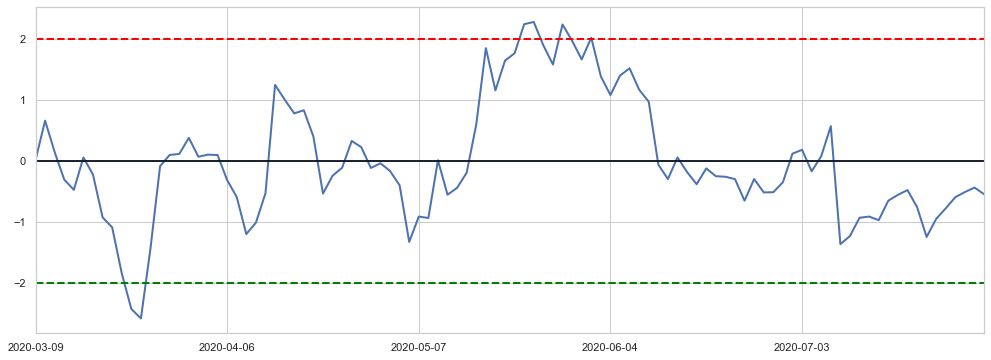

In [112]:
"""y_symbol = 'BBSE3'
x_symbol = 'ITSA4'"""

y_symbol = 'BRKM5'
x_symbol = 'LAME4'

period = 100
print('{}: {} / {}: {}'.format(y_symbol, data[y_symbol][0], x_symbol, data[x_symbol][0]))
mult.plot_residue(mult.residue(data[y_symbol], data[x_symbol], period))

In [113]:
# A Fazer
# 1. verificar se tá cointegrado em mais períodos
# 2. buscar oper somente dentro de um X dias de half-life
# 3. Stopar com X %
# 4. Take com X %

In [114]:
class BackTest(object):
    def __init__(self):
        self.day_start=None
        self.y_values=None
        self.x_values=None
        self.historic = Historic()
        self.list_historic=[]
        self.coef=None
        self.stop_executed=False
        self.cointegration=None
         
    def execute(self, desv_input=2, desc_input_max=2.5, desv_stop=3, desv_take=0, period=100, coef_fixed=False,
               adf=90, num_periods_cointegrated=3):
        
        # define properties
        self.period = period
        self.num_periods_cointegrated = num_periods_cointegrated
        
        days = data.index[::-1].tolist()
        for day in days:
            test = data[data.index <= day]
            if (len(test) < period):
                continue
                        
            if (self.day_start == None):
                self.day_start = day

            self.y_values, self.x_values = mult.get_values(test[y_symbol], test[x_symbol], period)
            
            # check se retornou a média após ter stoploss
            if (self.check_return_mean_after_stoploss()==False):
                continue                    
                
            self.cointegration = mult.check_cointegration(self.y_values, self.x_values, period)
            if(self.cointegration['is_stationary']==False):
                self.disintegrated(day)
                continue

            # check se é pra trabalhar com coieficientes fixo
            if (self.check_trade() and coef_fixed):
                resid = mult.residue(self.y_values, self.x_values, period, self.coef)
            else:
                self.coef = mult.coefficients(self.y_values, self.x_values, period)
                resid = mult.residue(self.y_values, self.x_values, period, self.coef)
            
            z_resid = mult.zscore(resid)
            
            if (self.check_trade() == False):
                # procura por short/long
                if (z_resid[0] >= desv_input and z_resid[0] <= desc_input_max):
                    self.short(day)
                # procura por long/short
                if (z_resid[0] <= -desv_input and z_resid[0] >= -desc_input_max):
                    self.long(day)

            if (self.check_trade()):
                self.historic.num_days+=1
                # check se short/long
                if (self.isShort()):
                    if (z_resid[0] >= desv_stop):# check stop loss
                        self.stop(day)
                    if (z_resid[0] <= desv_take):# check take profit
                        self.take(day)
                # check se long/short
                if (self.isLong()):
                    if (z_resid[0] <= -desv_stop):#  check stop loss
                        self.stop(day)
                    if (z_resid[0] >= desv_take):# check take profit
                        self.take(day)
        
        # os dados acabaram, então zera operação aberta se tiver
        self.zerar(day)

    def check_entry(self):
        if (self.check_trade()):
            return False
        
        # check num periods
        if (self.num_periods_cointegrated > 0):
            periods = mult.check_periods(self.y_values, self.x_values)
            if(self.num_periods_cointegrated > len(periods)):
                return False
        
        # check best adf
        if (self.cointegration['adf'] < self.adf):
            return False
        
        return True
        
    def check_return_mean_after_stoploss(self):
        if (self.stop_executed==False):
            return True
        
        resid = mult.residue(self.y_values, self.x_values, self.period)
        z_resid = mult.zscore(resid)
        if (abs(z_resid[0]) <= 0.2):
            self.stop_executed=False
            return True
        return False
            
    def take(self, day):
        self.define_historic_output(day, TypeOutput.TakeProfit)
        self.startNew()
        
    def stop(self, day):
        self.define_historic_output(day, TypeOutput.StopLoss)
        self.stop_executed=True
        self.startNew()
        
    def long(self, day):
        self.define_historic_input(day, TypeInput.LongShort)
    
    def short(self, day):
        self.define_historic_input(day, TypeInput.ShortLong)

    def disintegrated(self, day):
        if (self.check_trade() == False):
            return False
        self.define_historic_output(day, TypeOutput.Disintegrated)
        self.startNew()
        return True
    
    def zerar(self, day):
        if (self.check_trade() == False):
            return False
        self.define_historic_output(day, TypeOutput.Aberto)
        self.startNew()
        return True

    def define_historic_input(self, day, typeInput):
        self.historic.day_input=day
        self.historic.price_y_input=self.y_values[0]
        self.historic.price_x_input=self.x_values[0]
        self.historic.type_input=typeInput

    def define_historic_output(self, day, type_outPut):
        self.historic.day_output=day
        self.historic.price_y_output=self.y_values[0]
        self.historic.price_x_output=self.x_values[0]
        self.historic.type_output=type_outPut

    def startNew(self):
        self.list_historic.append(self.historic)
        self.historic = Historic()

    def isShort(self):
        return self.historic.type_input == TypeInput.ShortLong

    def isLong(self):
        return self.historic.type_input == TypeInput.LongShort
    
    def check_trade(self):
        return self.isShort() or self.isLong()
    
    def dataframe(self):
        rows = []
        for his in self.list_historic:
            rows.append(his.get())
        hist = pd.DataFrame(rows, columns=['Oper', 'Ent. Data', 'Ent. Pç Dep', 'Ent. Pç Ind', 'Sai. Data', 'Sai. Pç Dep',
                                           'Sai. Pç Ind', 'Sai. tipo', 'Result', "Retorno %", 'Dias'])
        return hist

In [115]:
coef_fixed = False
back = BackTest()
back.execute(period=period, desv_take=0, coef_fixed=coef_fixed)
hist = back.dataframe()
hist

,Oper,Ent. Data,Ent. Pç Dep,Ent. Pç Ind,Sai. Data,Sai. Pç Dep,Sai. Pç Ind,Sai. tipo,Result,Retorno %,Dias
0,LongShort,2020-02-28,26.889999,26.600000,2020-03-04,28.980000,27.700001,Disintegrated,98.999977,3.416148,3
1,LongShort,2020-03-23,10.070000,17.490000,2020-03-25,15.020000,20.030001,Disintegrated,240.999985,16.045271,2
2,ShortLong,2020-05-22,25.990000,25.350000,2020-06-04,27.219999,30.389999,TakeProfit,380.999947,15.029583,10
3,LongShort,2020-07-09,23.570000,35.369999,2020-07-16,24.240000,34.720001,Disintegrated,131.999779,5.445535,5


In [116]:
print('Nº Trades: {}'.format(len(hist)))
print('TakeProfit: {}'.format(hist['Result'][hist['Sai. tipo'] == 'TakeProfit'].sum()))
print('Disintegrated: {}'.format(hist['Result'][hist['Sai. tipo'] == 'Disintegrated'].sum()))
print('StopLoss: {}'.format(hist['Result'][hist['Sai. tipo'] == 'StopLoss'].sum()))
print('Aberto: {}'.format(hist['Result'][hist['Sai. tipo'] == 'Aberto'].sum()))

Nº Trades: 4
TakeProfit: 380.99994659423874
Disintegrated: 471.9997406005871
StopLoss: 0.0
Aberto: 0.0


# Visualiza no Gráfico

In [117]:
index=4
oper = hist.iloc[index]
day_start = oper['Ent. Data']
day_end = oper['Sai. Data']

test = data[data.index <= day_start]
test_stop = data[data.index <= day_end]
test_simu = data[(data.index >= day_start) & (data.index <= day_end)]

print('Days: {}'.format(abs(len(test)-len(test_stop))))

coef = mult.coefficients(test[y_symbol], test[x_symbol], period)
if(coef_fixed==False):
    coef=None

mult.plot_residue(mult.residue(test[y_symbol], test[x_symbol], period, coef))
mult.plot_residue(mult.residue(test_stop[y_symbol], test_stop[x_symbol], period, coef))

IndexError: single positional indexer is out-of-bounds

In [95]:
test_simu[::-1][[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')
#test_simu[[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')

In [97]:
test_simu[::-1][[y_symbol, x_symbol]]

,BRKM5,LAME4
Date,,
2020-03-20,11.80,17.610001
2020-03-23,10.07,17.490000
2020-03-24,11.40,19.290001
2020-03-25,15.02,20.030001
2020-03-26,19.23,20.850000
